In [5]:
#pip install geopy
#pip install folium

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, HeatMap
from sklearn.cluster import DBSCAN

from IPython.display import display
pd.set_option("display.max_columns", None)

In [89]:
# Load the events dataset (ensure your CSV file contains the necessary columns)
df = pd.read_csv('filtered_data/filtered_201903.csv', sep=None, engine="python", encoding="utf-8")

#df=df[abs(df['GoldsteinScale']) >= 10]
df = df.dropna(subset=['Actor1Code','Actor2Code', 'GoldsteinScale', 'ActionGeo_Lat', 'ActionGeo_Long'])
#df=df[df['IsRootEvent'] == 1]
#df=df[(df['NumMentions']) >= 2]


df = df[(df['Actor1CountryCode'].isin(['ITA', 'CHN'])) |(df['Actor1CountryCode'].isin(['ITA', 'CHN']))]

# Count the number of missing (NaN) values per row
df['missing_count'] = df.isnull().sum(axis=1)
# Sort by missing_count in ascending order so that rows with fewer missing values come first,
# then drop duplicates based on 'SOURCEURL', keeping the first (i.e. best) row for each URL.
df = df.sort_values('missing_count').drop_duplicates(subset=['SOURCEURL'], keep='first')
# Optionally, remove the helper column
df = df.drop(columns=['missing_count'])

In [91]:
n_events = df.shape[0]
avg_goldstein = df["GoldsteinScale"].mean()
avg_avgtone = df["AvgTone"].mean()
print(avg_goldstein)
print(avg_avgtone)
print(n_events)

3.204088050314465
0.4764729150754338
954


Distribuzione QuadClass:
          Event Type  Count  Percentage
  Verbal Cooperation    818       85.74
Material Cooperation     63        6.60
     Verbal Conflict     65        6.81
   Material Conflict      8        0.84


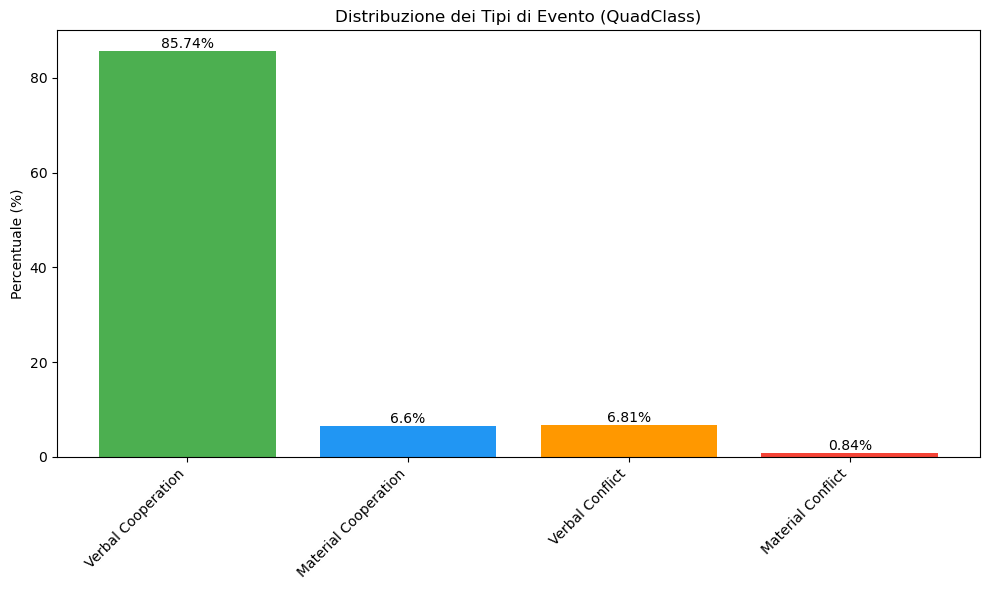

In [93]:
# 2. Calcola la distribuzione
quad_counts = df['QuadClass'].value_counts().sort_index()
percentages = (quad_counts / quad_counts.sum()) * 100

# 3. Mappa i codici QuadClass alle label
quad_labels = {
    1: 'Verbal Cooperation',
    2: 'Material Cooperation',
    3: 'Verbal Conflict',
    4: 'Material Conflict'
}

# 4. Crea un DataFrame con i risultati
result_df = pd.DataFrame({
    'Event Type': [quad_labels[q] for q in percentages.index],
    'Count': quad_counts.values,
    'Percentage': percentages.round(2).values
})

# 5. Stampa i risultati
print("Distribuzione QuadClass:")
print(result_df.to_string(index=False))

# 6. Visualizzazione
plt.figure(figsize=(10, 6))
bars = plt.bar(result_df['Event Type'], result_df['Percentage'], color=['#4CAF50', '#2196F3', '#FF9800', '#F44336'])

plt.title('Distribuzione dei Tipi di Evento (QuadClass)')
plt.ylabel('Percentuale (%)')
plt.xticks(rotation=45, ha='right')

# Aggiungi etichette con le percentuali
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [95]:
df

,GlobalEventID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
3146,833309708,20190325,201903,2019,2019.2329,CHNGOVMED,CHINA,CHN,NaN,NaN,NaN,NaN,GOV,MED,NaN,ITAGOVMED,ITALY,ITA,NaN,NaN,NaN,NaN,GOV,MED,NaN,0,57,57,5,1,8.0,5,1,5,1.202749,4,"Beijing, Beijing, China",CH,CH22,39.928900,116.388000,-1898541,4,"Milan, Lombardia, Italy",IT,IT09,45.466700,9.200000,-121726,4,"Milan, Lombardia, Italy",IT,IT09,45.466700,9.200000,-121726,20190325,https://www.globalcapital.com/article/b1dpb4qf...
1600,832437724,20190321,201903,2019,2019.2219,ITAGOVELI,FRANCO FRATTINI,ITA,NaN,NaN,NaN,NaN,GOV,ELI,NaN,CHNGOV,CHINESE,CHN,NaN,NaN,NaN,NaN,GOV,NaN,NaN,1,13,13,1,1,0.4,7,2,7,-0.393701,1,China,CH,CH,35.000000,105.000000,CH,1,China,CH,CH,35.000000,105.000000,CH,1,China,CH,CH,35.000000,105.000000,CH,20190321,https://www.mo4ch.com/2019/03/mo4chitaly-joini...
1598,832432689,20190321,201903,2019,2019.2219,ITAGOVELI,FRANCO FRATTINI,ITA,NaN,NaN,NaN,NaN,GOV,ELI,NaN,CHNGOV,CHINA,CHN,NaN,NaN,NaN,NaN,GOV,NaN,NaN,1,13,13,1,1,0.4,1,1,1,0.000000,1,Italy,IT,IT,42.833333,12.833333,IT,1,China,CH,CH,35.000000,105.000000,CH,1,Italy,IT,IT,42.833333,12.833333,IT,20190321,https://en.shafaqna.com/fn/185922/
1747,832601817,20190321,201903,2019,2019.2219,ITAGOVELI,FRANCO FRATTINI,ITA,NaN,NaN,NaN,NaN,GOV,ELI,NaN,CHNGOV,CHINESE,CHN,NaN,NaN,NaN,NaN,GOV,NaN,NaN,1,13,13,1,1,0.4,3,1,3,0.000000,3,"Washington, District of Columbia, United States",US,USDC,38.895100,-77.036400,531871,3,"Washington, District of Columbia, United States",US,USDC,38.895100,-77.036400,531871,3,"Washington, District of Columbia, United States",US,USDC,38.895100,-77.036400,531871,20190321,https://www.sott.net/article/409574-By-joining...
3185,833312965,20190325,201903,2019,2019.2329,ITAMED,ITALIAN,ITA,NaN,NaN,NaN,NaN,MED,NaN,NaN,CHNGOV,CHINESE,CHN,NaN,NaN,NaN,NaN,GOV,NaN,NaN,0,42,42,4,1,1.9,3,1,3,-0.665927,4,"Rome, Lazio, Italy",IT,IT07,41.900000,12.483300,-126693,4,"Beijing, Beijing, China",CH,CH22,39.928900,116.388000,-1898541,4,"Beijing, Beijing, China",CH,CH22,39.928900,116.388000,-1898541,20190325,https://www.euractiv.com/section/eu-china/news...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,832796795,20190322,201903,2019,2019.2247,ITA,ROME,ITA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHN,CHINA,CHN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,173,173,17,4,-5.0,6,2,6,1.669449,4,"Rome, Lazio, Italy",IT,IT07,41.900000,12.483300,-126693,4,"Beijing, Beijing, China",CH,CH22,39.928900,116.388000,-1898541,4,"Rome, Lazio, Italy",IT,IT07,41.900000,12.483300,-126693,20190322,https://jerseyeveningpost.com/news/world-news/...
2103,832799052,20190322,201903,2019,2019.2247,CHN,CHINESE,CHN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ITA,ITALY,ITA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,42,42,4,1,1.9,14,7,14,-9.499174,4,"Chenjiagang, Hubei, China",CH,CH12,29.699600,112.095000,11293287,1,Italy,IT,IT,42.833333,12.833333,IT,1,Italy,IT,IT,42.833333,12.833333,IT,20190322,http://banglamirrornews.com/2019/03/22/china-c...
2105,832802259,20190322,201903,2019,2019.2247,CHN,CHIN

In [97]:
# Initialize world map with multiple tile layers
world_map = folium.Map(location=[20, 0], zoom_start=2, tiles="CartoDB positron", control_scale=True)
folium.TileLayer('Stamen Terrain').add_to(world_map)
folium.TileLayer('OpenStreetMap').add_to(world_map)
folium.TileLayer('Stamen Toner').add_to(world_map)

# Define a scaling factor for marker size
scale_factor = 0.00001

# Create marker cluster for individual event markers
marker_cluster = MarkerCluster(name='Event Markers').add_to(world_map)

# Ensure critical data is available
df = df.dropna(subset=['GoldsteinScale', 'ActionGeo_Lat', 'ActionGeo_Long', 'Actor1Geo_FullName'])

# Extract lat/lon for clustering
coords = df[['ActionGeo_Lat', 'ActionGeo_Long']].values

# Apply DBSCAN clustering (adjust eps and min_samples as needed)
db = DBSCAN(eps=2.0, min_samples=5).fit(coords)
df['Cluster'] = db.labels_

# Dictionary to store cluster centers and info
cluster_centers = {}

# Iterate over clusters (ignoring noise, labeled as -1)
for cluster_label in set(db.labels_):
    if cluster_label == -1:
        continue  # Skip noise points

    # Get cluster points
    cluster_points = df[df['Cluster'] == cluster_label]
    
    # Compute cluster center (mean lat/lon)
    cluster_lat, cluster_lon = cluster_points[['ActionGeo_Lat', 'ActionGeo_Long']].mean().values
    
    # Use the most common "Actor1Geo_FullName" in the cluster as the region name
    mode_series = cluster_points['Actor1Geo_FullName'].mode()
    region_name = mode_series.iloc[0] if not mode_series.empty else "Unknown Region"
    
    count_events = len(cluster_points)
    # Save cluster information: center, region name, and event count
    cluster_centers[cluster_label] = (cluster_lat, cluster_lon, region_name, count_events)
    
    # Add a marker for the cluster on the map only if there are more than 10 events
    if count_events > 10:
        folium.Marker(
            location=[cluster_lat, cluster_lon],
            popup=f"{region_name} ({count_events} events)",
            icon=folium.Icon(color="darkblue", icon="info-sign")
        ).add_to(world_map)

# Loop through each event for individual markers
for idx, row in df.iterrows():
    lat, lon = row['ActionGeo_Lat'], row['ActionGeo_Long']
    val = row['GoldsteinScale']
    
    # Calculate radius based on the event's Goldstein scale
    radius = (np.exp(abs(val)) - 1) ** 1.2 * scale_factor
    color = 'red' if val < 0 else 'blue'
    
    # Retrieve event details
    actor1 = row.get('Actor1Code', 'Unknown')
    actor2 = row.get('Actor2Code', 'Unknown')
    source_url = row.get('SOURCEURL', '#')
    event_num = row.get('GlobalEventID', '#')
    
    # Create a popup with event details and a clickable source link
    popup_text = f"""
    <b>Event_Number:</b> {event_num}<br>
    <b>Actor1:</b> {actor1}<br>
    <b>Actor2:</b> {actor2}<br>
    <b>Goldstein Scale:</b> {val}<br>
    <a href="{source_url}" target="_blank">Source</a>
    """
    
    # Add the event marker to the cluster
    folium.CircleMarker(
        location=[lat, lon],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.2,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(marker_cluster)

# Add a heatmap layer for event intensity
heat_data = [[row['ActionGeo_Lat'], row['ActionGeo_Long']] for idx, row in df.iterrows()]
HeatMap(heat_data, name='Heat Map', radius=15, blur=10, min_opacity=0.3).add_to(world_map)

# Add a layer control widget to toggle between base layers and overlays
folium.LayerControl().add_to(world_map)

# Add a custom legend for the Goldstein Scale colors
legend_html = '''
     <div style="
     position: fixed;
     bottom: 50px; left: 50px; width: 250px; height: 90px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color: white;
     padding: 10px;">
     <b>Legend</b><br>
     <i class="fa fa-circle" style="color:red"></i> Negative (Goldstein Scale &lt; 0)<br>
     <i class="fa fa-circle" style="color:blue"></i> Positive (Goldstein Scale ≥ 0)
     </div>
     '''
world_map.get_root().html.add_child(folium.Element(legend_html))

# Save the resulting map to an HTML file
world_map.save('events_map.html')


In [98]:
#DBSCAN Clustering: Groups nearby events into meaningful regions.
#Reverse Geocoding: Converts cluster centers into readable city names.
#Clustered Region Markers: Adds labeled markers for event-heavy regions.

display(world_map)
#The colors represent the intensity of events in a given area. 

In [101]:
# Group by country and count the number of events
event_counts = df['Actor1CountryCode'].value_counts()

# Convert to DataFrame for better readability
event_counts_df = event_counts.reset_index()
event_counts_df.columns = ['Country', 'Number of Events']

# Display the result
print(event_counts_df)
# Remember that these are events filtered in a way that each event either includes italy or china or both
#No changed, the events are only between ITALY and CHINA

  Country  Number of Events
0     ITA               524
1     CHN               430
